<a href="https://colab.research.google.com/github/idjoopal/BurgerIndex2019/blob/master/%EC%8B%A4%EC%8A%B5_5_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

###이미지에서 고양이와 강아지를 분류하자!


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os  # 파일과 디렉토리 구조를 읽는데 사용
import numpy as np #  python list를 numpy array로 변환하고 필요한 matrix 연산을 수행한다.
import matplotlib.pyplot as plt # 그래프를 작성하고 training 및 validation data에 대한 이미지를 프리뷰

## 데이터 로드

캐글에서 <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs Cats</a> 데이터셋을 내려받아 준비한다.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 0s 0us/step


데이터셋의 구조는 아래와 같습니다.

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

내용을 압축해제한 뒤 training 및 validation set에 적합한 파일 경로로 변수를 할당한다.

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### 데이터에 대한 이해

얼마나 많은 고양이와 개의 이미지가 있는지 살펴봅시다.

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


편의를 위해 dataset을 preprocessing하고 네트워크를 학습할 때 사용할 변수를 설정한다.

In [ ]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

## 데이터 준비

네트워크에 데이터를 들이붓기 전에 이미지를 적절히 사전처리하여 float Tensor로 변환하자.

1. 디스크에서 이미지 읽기
2. 이러한 이미지의 콘텐츠를 디코딩하고 RGB 컨텐츠에 따라 적절한 그리드 형식으로 변환한다.
3. float Tensor로 변환한다.
4. Neural Network가 작은 입력 값 처리를 선호하기에 텐서를 0과 255 사이의 값에서 0과 1 사이의 값으로 다시 조정한다.

이 모든 작업은 `tf.keras`가 제공하는 `ImageDataGenerator`를 통해 수행할 수 있다. 디스크에서 이미지를 읽고 적절한 텐서 안으로 사전 처리할 수 있습니다.

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Training 및 Validation용 generator를 정의한 후 `flow_from_directory` 메소드는 디스크에서 이미지를 로드하고, 다시 스케일을 적용하며, 필요한 치수로 이미지 크기를 조정한다.

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')  

Found 2000 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### training image의 시각화

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

`next` 기능은 datset에서 batch를 반환한다. `next` 함수의 반환값은 `(x_train, y_train)`, x_train은 training image이며 y_train은 label이다.

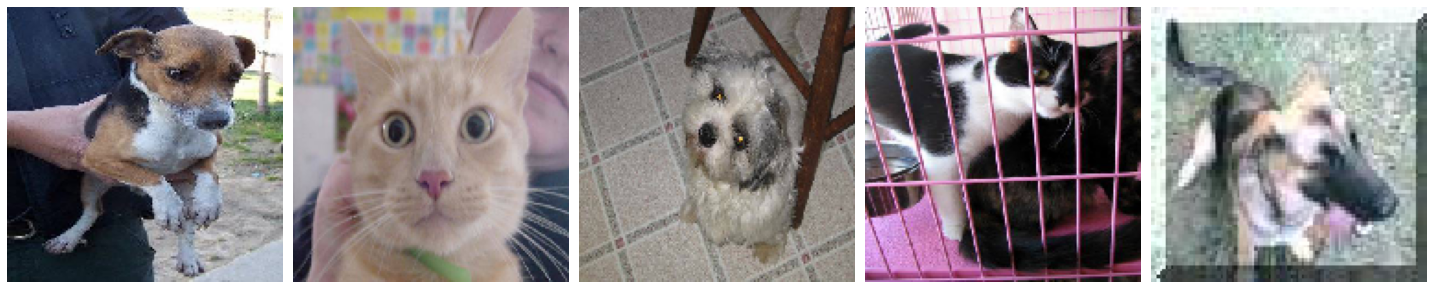

[1. 0. 1. 0. 1.]


In [ ]:
sample_training_images, sample_training_labels = next(train_data_gen)
plotImages(sample_training_images[:5])
print(sample_training_labels[:5])

In [ ]:
sample_training_images[0].shape  # 이미지 한 장당 가로세로 150픽셀 RGB컬러 이미지임을 알 수 있다

(150, 150, 3)

# 실습 MISSION
* CNN 뒤에 ReLU Activation Function을 적용한 512 fully connected Layer를 추가해보자.

* 그 뒤 binary classification이 가능하도록 1개의 출력값이 나오도록 다시 FC layer 한 층을 추가한다. 이 때 sigmoid를 활용한다.

힌트! 3차원 텐서가 흐르던 Conv 연산을 Dense로 다시 연결하려면 납작하게 1차원으로 눌러주는 작업이 필요하다..!


## 모델 만들기

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPool2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPool2D(),
    #### ANSWER ####
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    ################
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### 모델 컴파일하기

이 학습 자료에서는 *ADAM* optimizer 및 *Binary Cross Entropy* loss function을 선택한다. 각 training epoch에서 교육 및 검증 정확도를 보려면 `metrics` argumnet를 사용하면 된다.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 모델 학습시키기

`ImageDataGenerator` 클래스의 `fit_generator` 메소드를 사용하여 네트워크를 교육한다.

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
15/15 [==============================] - 9s 570ms/step - loss: 0.8955 - accuracy: 0.5005 - val_loss: 0.6924 - val_accuracy: 0.4944
Epoch 2/15
15/15 [==============================] - 8s 554ms/step - loss: 0.6824 - accuracy: 0.5657 - val_loss: 0.6686 - val_accuracy: 0.6429
Epoch 3/15
15/15 [==============================] - 8s 559ms/step - loss: 0.6415 - accuracy: 0.6282 - val_loss: 0.6161 - val_accuracy: 0.6730
Epoch 4/15
15/15 [==============================] - 8s 565ms/step - loss: 0.5739 - accuracy: 0.7142 - val_loss: 0.6108 - val_accuracy: 0.6752
Epoch 5/15
15/15 [==============================] - 9s 571ms/step - loss: 0.5664 - accuracy: 0.7094 - val_loss: 0.5924 - val_accuracy: 0.6853
Epoch 6/15
15/15 [==============================] - 8s 555ms/step - loss: 0.5231 - accuracy: 0.7382 - val_loss: 0.5804 - val_accuracy: 0.6853
Epoch 7/15
15/15 [==============================] - 8s 554ms/step - loss

### 학습 결과 시각화

이제 학습이 끝났으면 결과를 시각화 해보자.

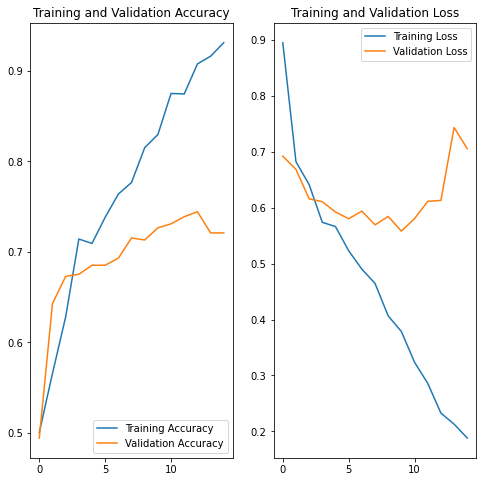

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###<font color='red'>잠깐 Quiz</font>
> 위 그래프를 통해 확인할 수 있는 문제점은?

## Data augmentation

`ImageDataGenerator`를 사용하여 다양한 변환을 데이터셋에 적용해보자.

### horizontal flip 적용

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


교육 예제에서 하나의 샘플 이미지를 추출한 후 5회 반복하여 동일한 이미지에 5회 augmentation이 적용되도록 한다.

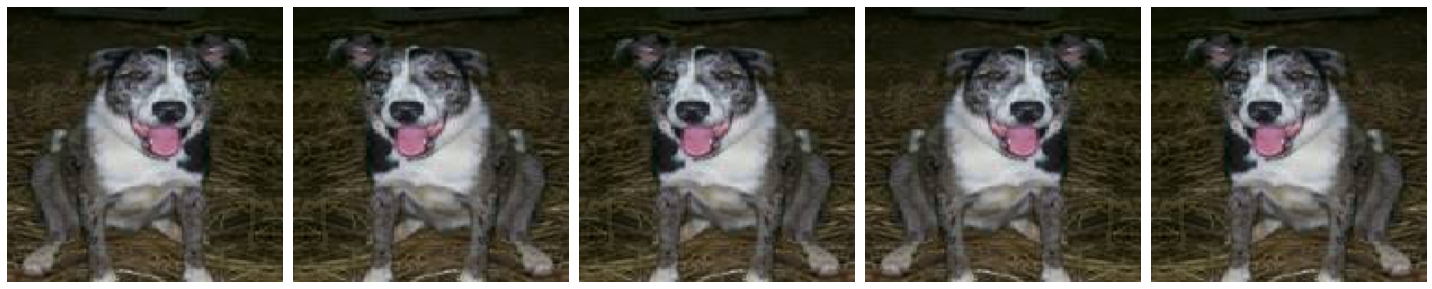

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Randomly rotate the image

rotation augmentation을 적용하여 학습 이미지가 무작위로 45도 회전하도록 해보자.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

Found 2000 images belonging to 2 classes.


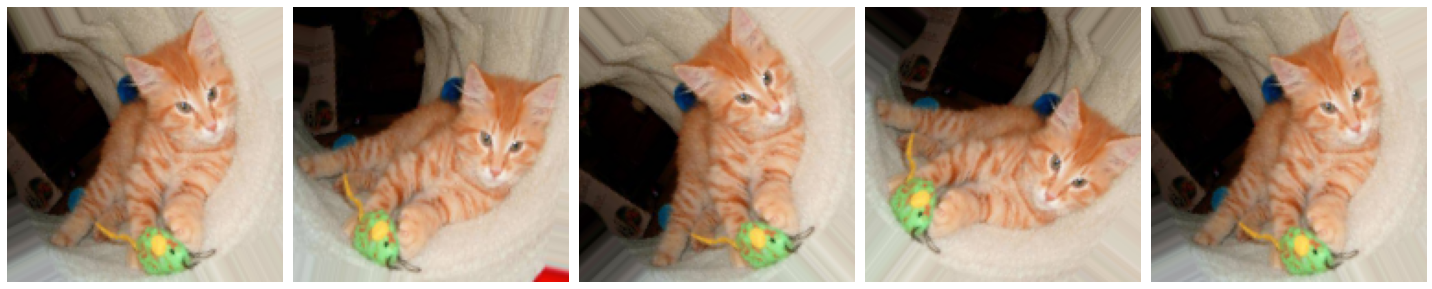

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### zoom augmentation 적용

zoom augmentation을 적용하고 이미지들에 무작위로 최대 50% 줌을 적용해보자.

In [ ]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)  # 50% ~ 150%

Found 2000 images belonging to 2 classes.


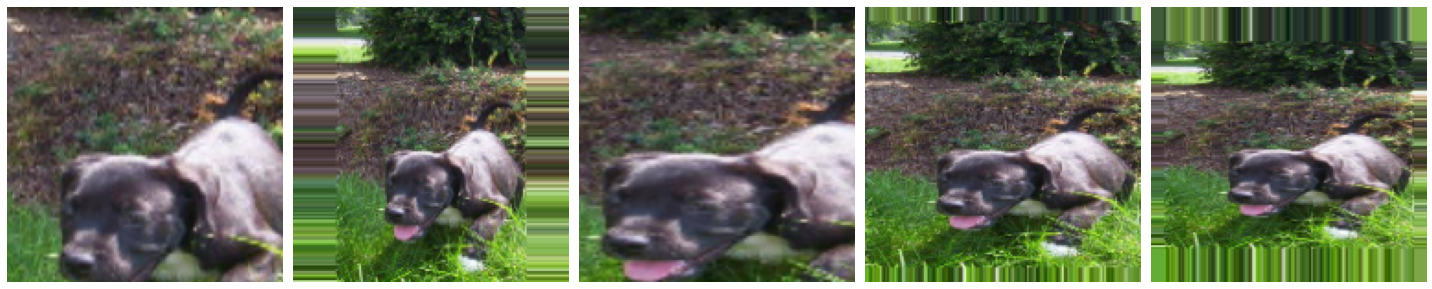

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 한 번에 적용하기

# 실습 MISSION

> 지금까지의 모든 augmentation을 적용하고 학습해보자

* 픽셀값이 0~1 범위가 되도록 rescale
* 좌우 45도 범위 회전 허용
* width shift 중앙 기준 20%범위 허용
* height shift 중앙 기준 25%범위 허용
* horizontal flip 허용
* zoom augmentation 확대/축소 10%까지 허용

[참고 Documentation](https://keras.io/preprocessing/image/)

In [ ]:
image_gen_train = ImageDataGenerator(
                    #### ANSWER #### 
                    rescale=1./255
                    , rotation_range=45
                    , width_shift_range=0.2
                    , height_shift_range=0.25
                    , horizontal_flip=True
                    , zoom_range=0.1
                    ################
                    )

Found 2000 images belonging to 2 classes.


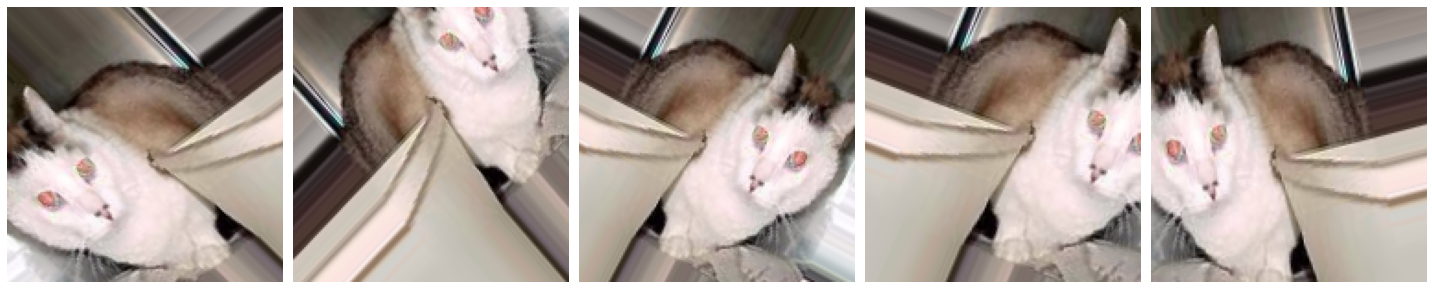

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### validation data generator 만들기


일반적으로 data augmentation은 traiing example에만 적용하므로, validation data generator는 `ImageDataGenerator`로부터 `rescale`만 적용하여 작성하도록 하자.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# 실습 MISSION

아래 네트워크의 모든 Dense 레이어 앞부분에 dropout을 적용하자.

30% 만큼의 노드를 매번 비활성화 한채로 학습해야 한다.

In [ ]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPool2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dropout(rate=0.3),
    Dense(512, activation='relu'),
    Dropout(rate=0.3),
    Dense(1, activation='sigmoid')
])
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

In [ ]:
model_new.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

### 모델 학습시키기


교육 예제에 Data Augmentation을 도입하고 네트워크에 dropout을 추가한 후 네트워크를 학습시키자.

In [ ]:
epochs_new = 50

In [ ]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs_new,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/50
15/15 [==============================] - 17s 1s/step - loss: 0.4499 - accuracy: 0.7831 - val_loss: 0.5071 - val_accuracy: 0.7400
Epoch 2/50
15/15 [==============================] - 17s 1s/step - loss: 0.4306 - accuracy: 0.7991 - val_loss: 0.4970 - val_accuracy: 0.7589
Epoch 3/50
15/15 [==============================] - 17s 1s/step - loss: 0.4292 - accuracy: 0.7965 - val_loss: 0.5178 - val_accuracy: 0.7321
Epoch 4/50
15/15 [==============================] - 17s 1s/step - loss: 0.4445 - accuracy: 0.7959 - val_loss: 0.5130 - val_accuracy: 0.7522
Epoch 5/50
15/15 [==============================] - 16s 1s/step - loss: 0.4366 - accuracy: 0.7954 - val_loss: 0.5136 - val_accuracy: 0.7422
Epoch 6/50
15/15 [==============================] - 16s 1s/step - loss: 0.4130 - accuracy: 0.8109 - val_loss: 0.5238 - val_accuracy: 0.7288
Epoch 7/50
15/15 [==============================] - 16s 1s/step - loss: 0.4343 - accuracy: 0.7965 - val_loss: 0.5139 - val_accuracy: 0.7656
Epoch 8/50
15/15 [==

### 학습 결과 시각화

학습이 끝난 후 새로운 모델을 시각화 해보자. overfitting이 크게 줄어든 것을 확인할 수 있다. 정확성을 높이기 위해서는 모델을 더 충분히 훈련시켜야 한다.

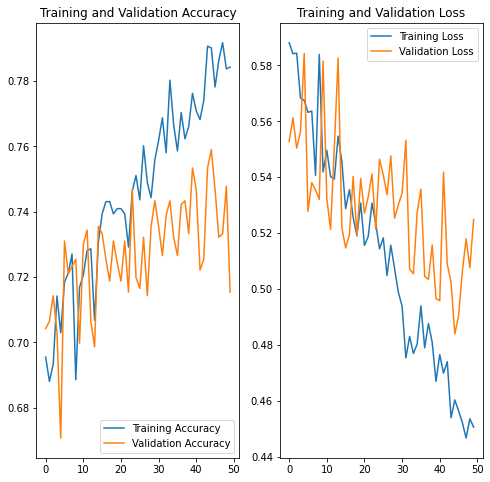

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(epochs_new)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 학습된 모델로 Inference해보기

개와 고양이 이미지를 내려받는다.

In [ ]:
!wget -O dog_sample.jpg https://www.guidingeyes.org/wp-content/uploads/2020/01/1-1.jpg
!wget -O cat_sample.jpg https://www.rd.com/wp-content/uploads/2019/11/cat-10-e1573844975155-768x519.jpg

--2020-11-11 04:37:34--  https://www.guidingeyes.org/wp-content/uploads/2020/01/1-1.jpg
Resolving www.guidingeyes.org (www.guidingeyes.org)... 34.73.250.10
Connecting to www.guidingeyes.org (www.guidingeyes.org)|34.73.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49500 (48K) [image/jpeg]
Saving to: ‘dog_sample.jpg’

dog_sample.jpg      100%[===================>]  48.34K  --.-KB/s    in 0.09s   

2020-11-11 04:37:35 (519 KB/s) - ‘dog_sample.jpg’ saved [49500/49500]

--2020-11-11 04:37:35--  https://www.rd.com/wp-content/uploads/2019/11/cat-10-e1573844975155-768x519.jpg
Resolving www.rd.com (www.rd.com)... 104.18.25.214, 104.18.24.214, 2606:4700::6812:18d6, ...
Connecting to www.rd.com (www.rd.com)|104.18.25.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44988 (44K) [image/jpeg]
Saving to: ‘cat_sample.jpg’

cat_sample.jpg      100%[===================>]  43.93K  --.-KB/s    in 0s      

2020-11-11 04:37:35 (146 MB/s) - ‘ca

이미지를 학습시킨 모델에 맞추어 rescale 후 (1, 150, 150, 3)로 변환시킨다.

In [ ]:
# keras 라이브러리를 이용한 방법
def img2input_keras(path, target_size):
  img_show = plt.imread(path)
  plt.imshow(img_show)
  tmp = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
  tmp = tf.keras.preprocessing.image.img_to_array(tmp)
  tmp = tmp/255.
  tmp = np.expand_dims(tmp, axis=0)
  print(tmp.shape)
  return tmp

(1, 150, 150, 3)


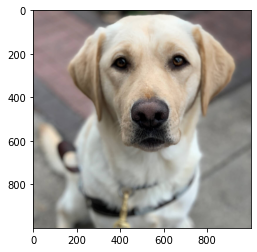

In [ ]:
dog_input = img2input_keras('dog_sample.jpg', (150, 150))

(1, 150, 150, 3)


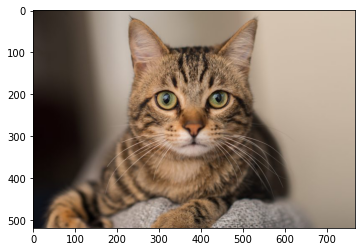

In [ ]:
cat_input = img2input_keras('cat_sample.jpg', (150, 150))

#### 첫 번째 모델(overfitting)의 추론 결과

In [ ]:
print('dog image -> ', model.predict(dog_input))

dog image ->  [[0.88076377]]


In [ ]:
print('cat image -> ',model.predict(cat_input))

cat image ->  [[0.12483119]]


### 두 번째 모델(img augmentation, dropout)의 추론 결과

In [ ]:
print('with new model, dog image -> ', model_new.predict(dog_input))

with new model, dog image ->  [[0.8660788]]


In [ ]:
print('with new model, cat image -> ', model_new.predict(cat_input))

with new model, cat image ->  [[0.4599507]]
